In [1]:
# Awareness Campaign - Objective-based Modeling Pipeline

# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import Ridge, LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import os

In [4]:
# 2. Load Data
df = pd.read_csv("../data/meta_ads_cleaned.csv")
df = df[df['Objective'] == 'Awareness'].copy()
df.head()

,Campaign name,Campaign Delivery,Platforme,Device,Placement,Objective,Result indicator,Ad set budget,Ad set budget type,Amount spent,...,Cost per app install (USD),Adds to cart,Adds to cart conversion value,Cost per add to cart (USD),Checkouts Initiated,Checkouts initiated conversion value,Cost per checkout initiated (USD),Landing page views,Cost per landing page view (USD),Cost per purchase (USD)
0,SO/2024/0281 - Campagne Ramadan - Instagram - ...,inactive,Instagram,In-app,Feed,Awareness,reach,0.28,Using ad set budget,0.28,...,0.000000,0,0.0,0.000000,0,0.0,0.000000,0,0.000000,0.000000
4,SO/2024/0556 - Orange - Lancement_campagne_Dat...,not_delivering,Instagram,Desktop,Feed,Awareness,reach,191.10,Using ad set budget,191.10,...,0.000000,5,0.0,38.220000,103,0.0,1.855340,32,5.971875,0.000000
5,SO/2024/0576 - Orange - Lancement posts digita...,not_delivering,Audience Network,In-app,Ads on Reels,Awareness,reach,399.41,Using ad set budget,399.41,...,2.450368,43,0.0,9.288605,1653,1222.7,0.241627,408,0.978946,66.568333
10,SO/2024/0581 - Orange - Campagne Achat options...,not_delivering,Instagram,In-app,Feed,Awareness,reach,41.88,Using ad set budget,41.88,...,0.000000,2,0.0,20.940000,113,0.0,0.370619,6,6.980000,0.000000
13,SO/2024/0071 - Orange - Lancement_Campagne BB ...,not_delivering,Facebook,In-app,Facebook Reels,Awareness,reach,28.49,Using ad set budget,28.49,...,0.000000,2,755.1,14.245000,75,0.0,0.379867,86,0.331279,0.000000


In [5]:
# 3. Initial Cleanup
columns_to_drop = [
    "Campaign name", "Campaign Delivery", "Objective", "Result indicator",
    "Attribution setting", "Date created", "Starts", "Ends"
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [18]:
# 4. Select relevant KPIs for Awareness (video + engagement + spend)
features_to_check = [
    "Amount spent", "Reach", "Impressions", "Frequency",
    "CPM (cost per 1,000 impressions) (USD)",
    "Cost per 1,000 Accounts Center accounts reached (USD)",
    "Views", "Landing page views", "Cost per landing page view (USD)",
    # Video-related
    "3-second video plays", "Video plays at 25%", "Video plays at 50%",
    "Video plays at 75%", "Video plays at 95%", "Video plays at 100%",
    "Video average play time", "Video plays",
    # Engagement-related
    "Post engagements", "Post reactions", "Post saves", "Post shares",
    "Page engagement", "Cost per Page engagement (USD)", "Cost per post engagement (USD)"
]

In [23]:
# 5. Drop NA and ensure numeric
X_raw = df[features_to_check].copy()
X_raw = X_raw.apply(pd.to_numeric, errors='coerce').dropna()

In [24]:
# 6. Power Transformation
power = PowerTransformer(method='yeo-johnson')
df_power = pd.DataFrame(
    power.fit_transform(X_raw),
    columns=X_raw.columns
)
power_skew = df_power.skew()

In [25]:
# Save transformer
os.makedirs("models", exist_ok=True)
joblib.dump(power, "models/awareness_power_transformer.joblib")


['models/awareness_power_transformer.joblib']

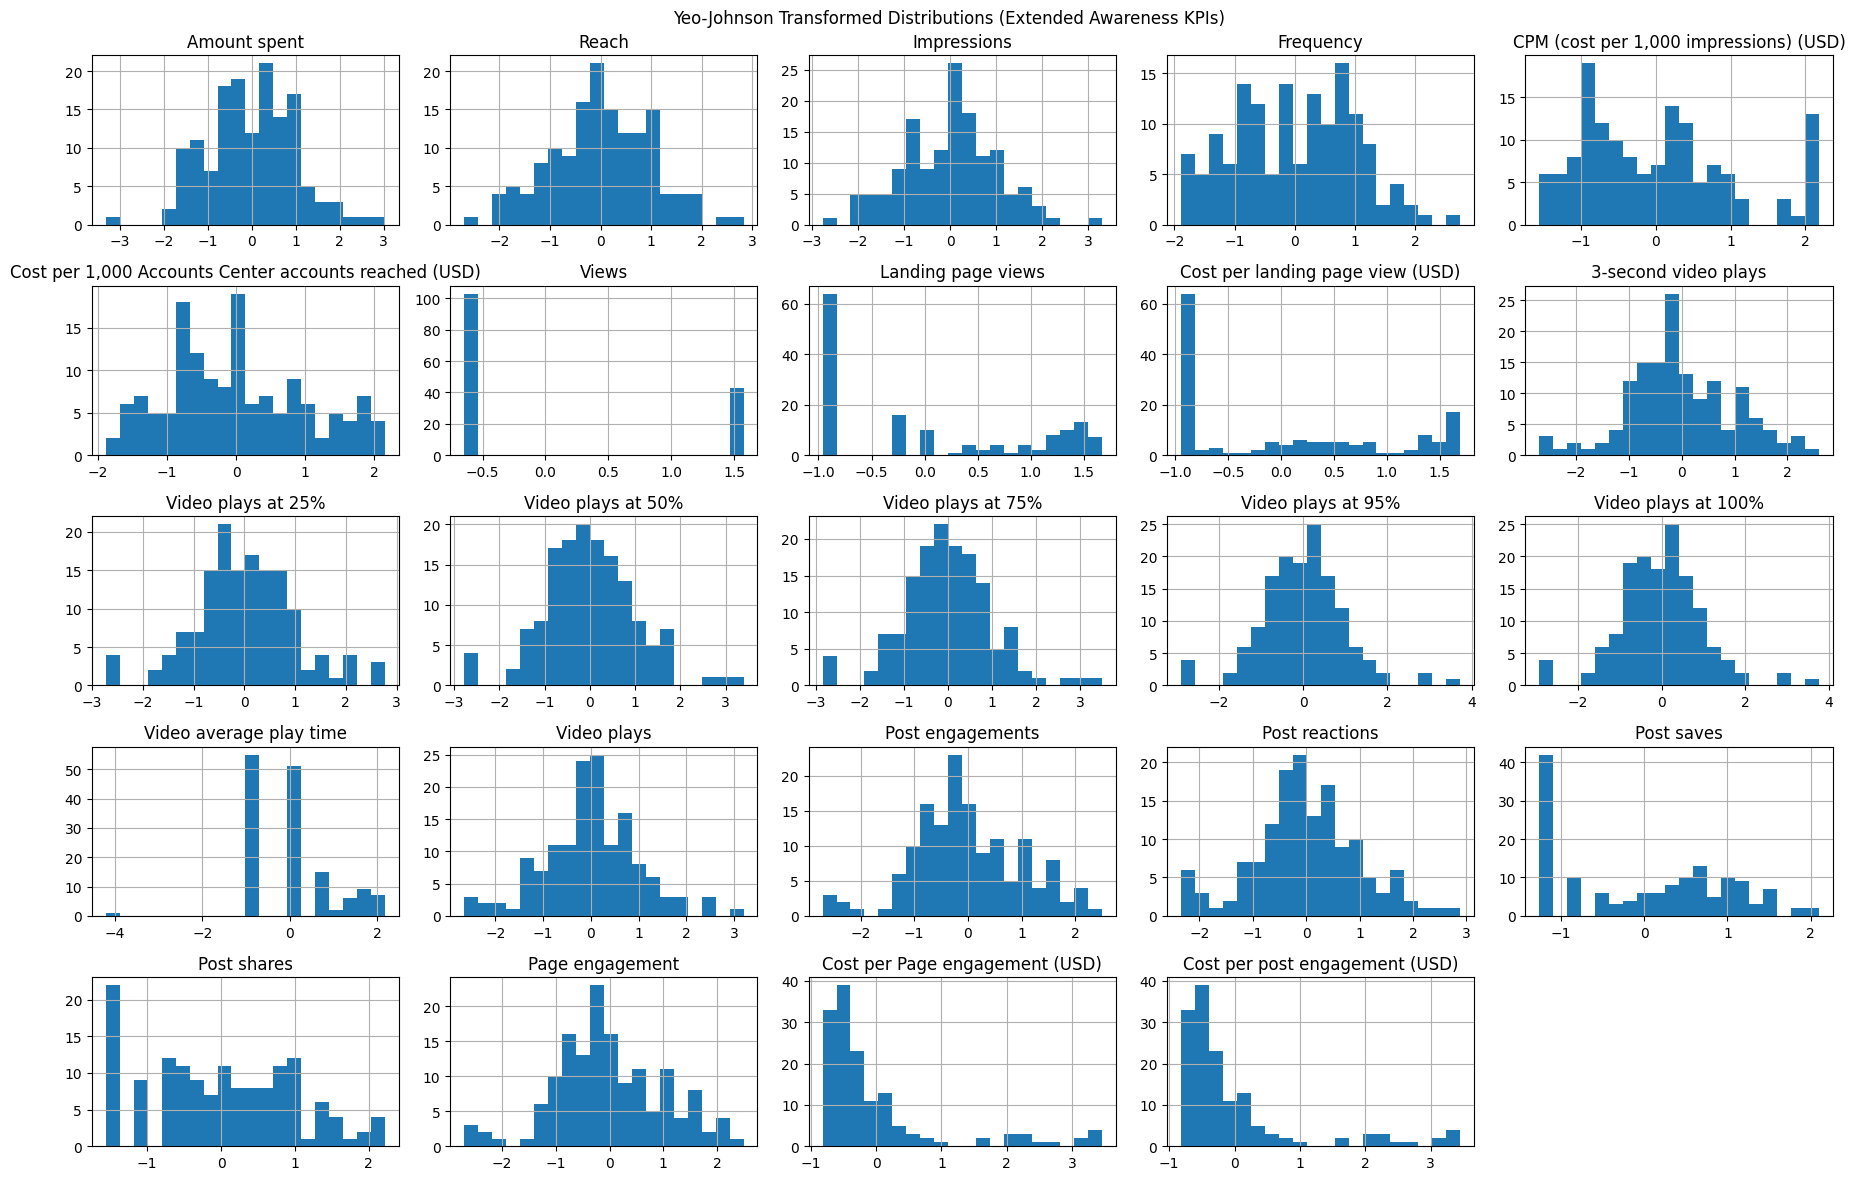

In [26]:
# 7. Visual Check
df_power.hist(bins=20, figsize=(18, 12))
plt.suptitle("Yeo-Johnson Transformed Distributions (Extended Awareness KPIs)")
plt.tight_layout()
plt.show()

In [27]:
# 8. Modeling Setup
target_cols = ["Reach", "Impressions"]
feature_cols = df_power.columns.difference(target_cols)

X = df_power[feature_cols].copy()
y = df_power[target_cols].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
# 9. Define models
models = {
    "Linear Regression": MultiOutputRegressor(LinearRegression()),
    "Ridge Regression": MultiOutputRegressor(Ridge(alpha=1.0)),
    "Random Forest": MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    "Bayesian Ridge": MultiOutputRegressor(BayesianRidge())
}

In [29]:
# 10. Train and Evaluate
best_model = None
best_score = -np.inf
metrics_summary = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse_reach = np.sqrt(mean_squared_error(y_test.iloc[:, 0], y_pred[:, 0]))
    r2_reach = r2_score(y_test.iloc[:, 0], y_pred[:, 0])
    mae_reach = mean_absolute_error(y_test.iloc[:, 0], y_pred[:, 0])

    rmse_impr = np.sqrt(mean_squared_error(y_test.iloc[:, 1], y_pred[:, 1]))
    r2_impr = r2_score(y_test.iloc[:, 1], y_pred[:, 1])
    mae_impr = mean_absolute_error(y_test.iloc[:, 1], y_pred[:, 1])

    print(f"{name}")
    print(f"Reach - RMSE: {rmse_reach:.4f} | MAE: {mae_reach:.4f} | R²: {r2_reach:.4f}")
    print(f"Impressions - RMSE: {rmse_impr:.4f} | MAE: {mae_impr:.4f} | R²: {r2_impr:.4f}")
    print("-" * 50)

    metrics_summary.append({
        "Model": name,
        "Reach RMSE": rmse_reach,
        "Reach MAE": mae_reach,
        "Reach R2": r2_reach,
        "Impr RMSE": rmse_impr,
        "Impr MAE": mae_impr,
        "Impr R2": r2_impr
    })

    if r2_reach + r2_impr > best_score:
        best_score = r2_reach + r2_impr
        best_model = model
        best_name = name

metrics_df = pd.DataFrame(metrics_summary)

Linear Regression
Reach - RMSE: 0.2510 | MAE: 0.1601 | R²: 0.9510
Impressions - RMSE: 0.1955 | MAE: 0.1314 | R²: 0.9681
--------------------------------------------------
Ridge Regression
Reach - RMSE: 0.2491 | MAE: 0.1744 | R²: 0.9517
Impressions - RMSE: 0.2007 | MAE: 0.1409 | R²: 0.9664
--------------------------------------------------
Random Forest
Reach - RMSE: 0.4737 | MAE: 0.3392 | R²: 0.8253
Impressions - RMSE: 0.3428 | MAE: 0.2473 | R²: 0.9021
--------------------------------------------------
Bayesian Ridge
Reach - RMSE: 0.2465 | MAE: 0.1707 | R²: 0.9527
Impressions - RMSE: 0.1995 | MAE: 0.1405 | R²: 0.9668
--------------------------------------------------


In [30]:
# 11. Cross-validation
cv_r2 = cross_val_score(best_model, X, y, scoring='r2', cv=5)
cv_mse = -cross_val_score(best_model, X, y, scoring='neg_mean_squared_error', cv=5)
cv_mae = -cross_val_score(best_model, X, y, scoring='neg_mean_absolute_error', cv=5)


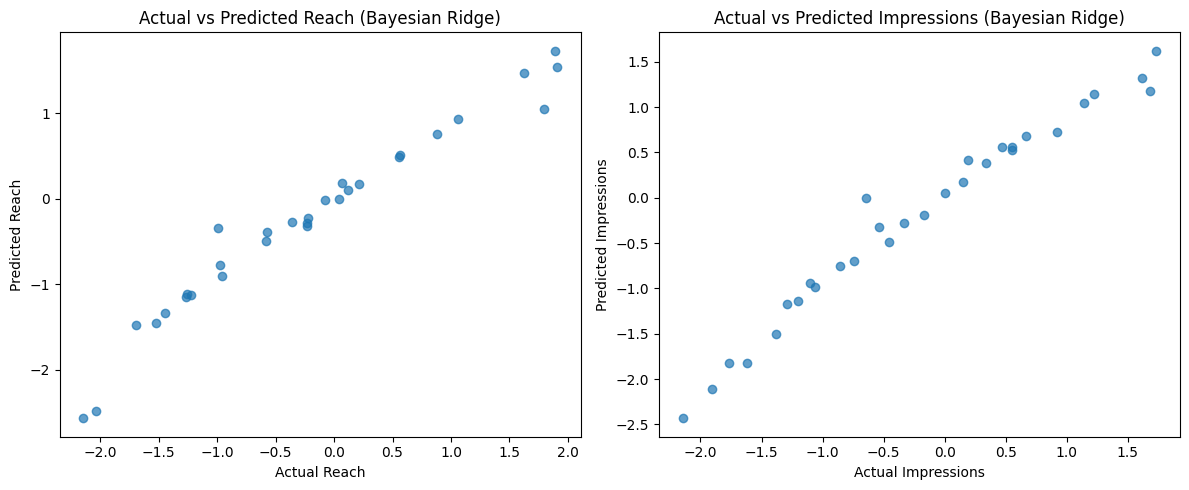

In [31]:
# 12. Actual vs Predicted Plots
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test.iloc[:, 0], y_pred_best[:, 0], alpha=0.7)
plt.xlabel("Actual Reach")
plt.ylabel("Predicted Reach")
plt.title(f"Actual vs Predicted Reach ({best_name})")

plt.subplot(1, 2, 2)
plt.scatter(y_test.iloc[:, 1], y_pred_best[:, 1], alpha=0.7)
plt.xlabel("Actual Impressions")
plt.ylabel("Predicted Impressions")
plt.title(f"Actual vs Predicted Impressions ({best_name})")

plt.tight_layout()
plt.show()

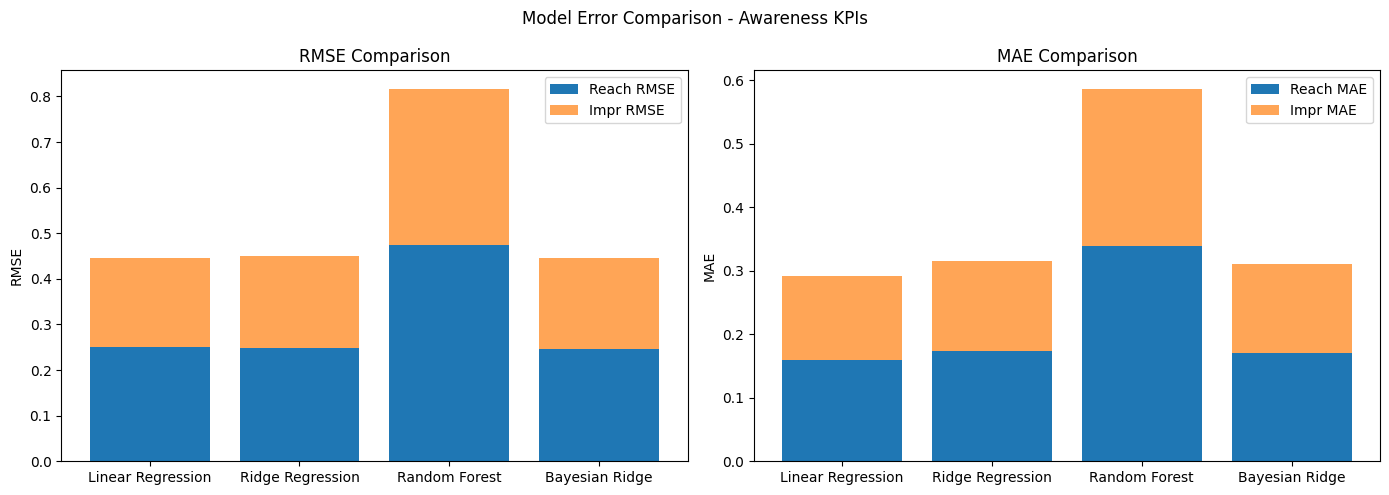

In [32]:
# 13. Error Comparison Charts
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].bar(metrics_df['Model'], metrics_df['Reach RMSE'], label='Reach RMSE')
axs[0].bar(metrics_df['Model'], metrics_df['Impr RMSE'], bottom=metrics_df['Reach RMSE'], label='Impr RMSE', alpha=0.7)
axs[0].set_title('RMSE Comparison')
axs[0].legend()
axs[0].set_ylabel("RMSE")

axs[1].bar(metrics_df['Model'], metrics_df['Reach MAE'], label='Reach MAE')
axs[1].bar(metrics_df['Model'], metrics_df['Impr MAE'], bottom=metrics_df['Reach MAE'], label='Impr MAE', alpha=0.7)
axs[1].set_title('MAE Comparison')
axs[1].legend()
axs[1].set_ylabel("MAE")

plt.suptitle("Model Error Comparison - Awareness KPIs")
plt.tight_layout()
plt.show()

In [33]:
# 14. Save best model
joblib.dump(best_model, f"models/{best_name.lower().replace(' ', '_')}_awareness_model.joblib")
joblib.dump(list(feature_cols), "models/awareness_model_features.pkl")

['models/awareness_model_features.pkl']

In [34]:
# 15. Summary
print(f"""
# ✅ Awareness Campaign Modeling Summary (Extended KPIs)

We tested 4 models to predict Reach and Impressions using extended awareness KPIs.

🔹 **Best Model:** {best_name}
📈 CV Avg R²: {np.mean(cv_r2):.4f} | RMSE: {np.mean(np.sqrt(cv_mse)):.4f} | MAE: {np.mean(cv_mae):.4f}
📦 Saved as: `{best_name.lower().replace(' ', '_')}_awareness_model.joblib`
📁 Features: `awareness_model_features.pkl`

Visual and numerical validation confirm prediction quality.
""")


# ✅ Awareness Campaign Modeling Summary (Extended KPIs)

We tested 4 models to predict Reach and Impressions using extended awareness KPIs.

🔹 **Best Model:** Bayesian Ridge
📈 CV Avg R²: 0.9246 | RMSE: 0.2610 | MAE: 0.1934
📦 Saved as: `bayesian_ridge_awareness_model.joblib`
📁 Features: `awareness_model_features.pkl`

Visual and numerical validation confirm prediction quality.

